# Applying Seq2Seq Model with Attention in Sorting Problems

---


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()
print(use_cuda)

True


## Generate Data

In [2]:
def next_batch(batch_size, seq_len, input_size=10):
    data = torch.LongTensor(batch_size, seq_len).random_() % input_size
    labels = torch.sort(data, 1)[0].view(batch_size, seq_len)
    
    #data_onehot = torch.zeros(batch_size, seq_len, input_size)
    #data_onehot.scatter_(2, data, 1)
    
    data = Variable(data)
    labels = Variable(labels)
    
    if use_cuda:
        data = data.cuda()
        labels = labels.cuda()
        
    return data, labels

## The Seq2Seq Model

In [3]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = embedded.view(-1,1,self.hidden_size)
        output, hidden = self.gru(output, hidden)
        
        return output, hidden

    
    def init_hidden(self, batch_size):
        result = Variable(torch.zeros(1, batch_size, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [4]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, batch_first=True)
        
        # Attention Mechanism
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.attn_combine = Variable(torch.randn(hidden_size, 1), requires_grad=True)
        if use_cuda:
            self.attn_combine = self.attn_combine.cuda()
    
        self.fc = nn.Linear(hidden_size, output_size)
        
        
    def forward(self, input, hidden, enc_outs):
        # Set initial states
        #x = x.transpose(0,1) # (batch_size, seq_len, input_size) -> (seq_len, batch_size, input_size)
        batch_size, seq_len = enc_outs.data.size()[:2]
        
        s = hidden # hidden state of RNN
            
        attn_weights = []
        # Attention Mechanism
        for j in range(seq_len):
            a = F.tanh(self.attn(torch.cat((enc_outs[:,j], s[0]), 1)))
            a = torch.mm(a, self.attn_combine)
            attn_weights.append(a)
            
        attn_weights = torch.cat(attn_weights, 1)
        attn_weights = F.softmax(attn_weights)
        
        # Input of RNN
        embedded = self.embedding(input)
        c = torch.bmm(attn_weights.view(batch_size,1,-1), enc_outs)
        comb = torch.cat((c[:,0], embedded), 1)
        output, hidden = self.gru(comb.view(batch_size,1,-1), s)
        output = self.fc(output.view(batch_size, -1)).view(batch_size, 1, -1)
        
        return output, hidden, attn_weights

    

In [5]:
input_size = 20
hidden_size = 10

In [6]:
encoder = EncoderRNN(input_size, hidden_size)
if use_cuda:
    encoder = encoder.cuda()

In [7]:
decoder = AttnDecoderRNN(hidden_size, input_size)
if use_cuda:
    decoder = decoder.cuda()

In [10]:
batch_size = 128
seq_len = 15

for cnt in range(5000):
    if cnt==0:
        learning_rate = 1.
        encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
        decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
    elif cnt==1500:
        learning_rate = .5
        encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
        decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
    elif cnt==3000:
        learning_rate = .25
        encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
        decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
    elif cnt==4000:
        learning_rate = .125
        encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
        decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
    elif cnt==4500:
        learning_rate = .0625
        encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
        decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
    
    encoder.zero_grad()
    decoder.zero_grad()
    
    x, y = next_batch(batch_size, seq_len, input_size)
    
    h = encoder.init_hidden(batch_size)
    enc_outs = []
    for i in range(seq_len):
        enc_out, h = encoder(x[:,i], h)
        enc_outs.append(enc_out)
    enc_outs = torch.cat(enc_outs, 1)
    
    # make dec_in
    dummies = torch.LongTensor(batch_size, 1).zero_()
    if use_cuda:
        dummies = dummies.cuda()
        
    dec_in = torch.cat([dummies, y[:,:-1].data], 1)
    dec_in = Variable(dec_in)
    if use_cuda:
        dec_in = dec_in.cuda()
        
    dec_outs = []
    for i in range(seq_len):
        dec_out, h, _ = decoder(dec_in[:, i], h, enc_outs)
        dec_outs.append(dec_out)
    dec_outs = torch.cat(dec_outs, 1)

    loss = 0
    for i in range(seq_len):
        loss += criterion(dec_outs[:,i], y[:,i])
    print(cnt, loss.data.cpu().numpy(), end='\r')
    loss.backward()
    
    nn.utils.clip_grad_norm(encoder.parameters(), 1)
    nn.utils.clip_grad_norm(decoder.parameters(), 1)
    for p in encoder.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    for p in decoder.parameters():
        p.data.add_(-learning_rate, p.grad.data)

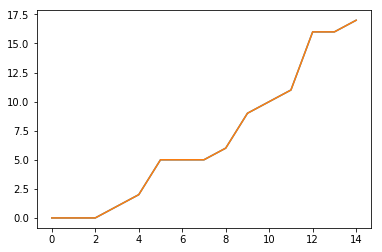

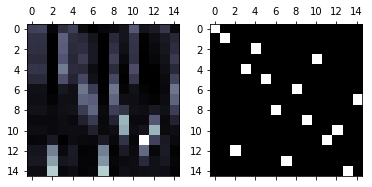

In [26]:
batch_size = 4
seq_len = 15

x, y = next_batch(batch_size, seq_len, input_size)


h = encoder.init_hidden(batch_size)
enc_outs = []
for i in range(seq_len):
    enc_out, h = encoder(x[:,i], h)
    enc_outs.append(enc_out)
enc_outs = torch.cat(enc_outs, 1)

dec_in = torch.LongTensor(batch_size).zero_()
dec_in = Variable(dec_in)
if use_cuda:
    dec_in = dec_in.cuda()

dec_outs = []
attns = []
for i in range(seq_len):
    dec_out, h, attn = decoder(dec_in, h, enc_outs)
    dec_in = Variable(dec_out.data.topk(1)[1]).view(batch_size)
    if use_cuda:
        dec_in = dec_in.cuda()
    dec_outs.append(dec_out)
    attns.append(attn.view(batch_size, 1, -1))
    
dec_outs = torch.cat(dec_outs, 1)
attns = torch.cat(attns, 1)
    
plt.plot(np.argmax(dec_outs.data[0].cpu().numpy(), 1))
plt.plot(y.data[0].cpu().numpy())
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.matshow(attns.data[0].cpu().numpy(), cmap='bone')
d = x.data[0].cpu().numpy()
ax2.matshow(np.eye(len(d))[np.argsort(d)], cmap='bone')